# Tutorial 10b - Custom Coating Types

### November 2024

This tutorial shows how new coating types can be defined in Optiland. A coating is a property of a surface, whether transmissive or reflective, which impacts the intensity and/or polarization state of light interacting with it.

In this example, we will define a transmissive coating that has a gradient-like transmission profile. We start by importing the BaseCoating class, which is the base class for all coating types. We also import other required modules.

In [1]:
from optiland.coatings import BaseCoating

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optiland import optic

When defining a coating in Optiland, we only need to define two methods:

1. reflect - defines how rays reflect on the surface
2. transmit - defines how rays transmit through the surface

Both methods accept the input rays and the surface normal on the surface at the ray intersection locations. They return the modified rays.

We will define a gradient coating with a very simple transmissive formula:

$T(x) = 0.01x + 0.5$

where

- T is the transmission of the ray
- x is the local x position of the ray on the surface

In [3]:
class GradientCoating(BaseCoating):
    def reflect(self, rays, nx, ny, nz):
        # for reflection, we leave the rays unchanged
        return rays

    def transmit(self, rays, nx, ny, nz):
        rays.i = (
            rays.x * 0.01 + 0.5
        )  # apply gradient to ray intensity based on ray x position
        return rays

Now, we will define a simple singlet and we will assign this coating to the first surface. We do this by passing the custom coating to the add_surface method, as shown here.

In [4]:
class Singlet(optic.Optic):
    """Singlet lens with a gradient coating."""

    def __init__(self):
        super().__init__()

        # define the coating here
        coating = GradientCoating()

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            thickness=7,
            radius=19.93,
            is_stop=True,
            material="N-SF11",
            coating=coating,
        )  # <-- Assign gradient coating to surface
        self.add_surface(index=2, thickness=21.48)
        self.add_surface(index=3)

        # add aperture
        self.set_aperture(aperture_type="EPD", value=25)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0)
        self.add_field(y=7)
        self.add_field(y=10)

        # add wavelength
        self.add_wavelength(value=0.55, is_primary=True)

Let's create and draw the singlet lens.

In [5]:
singlet = Singlet()

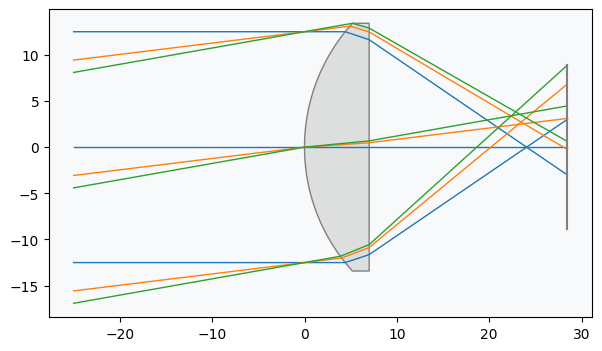

In [6]:
singlet.draw()

To view the impact of the coating, we will trace rays through the largest field point, then plot the ray transmission as a function of the intersection point on the first surface. This is done via a simple call to the `trace` method of the singlet instance. The final rays (at the image surface) are also stored, but we will not use them here.

In [7]:
rays_out = singlet.trace(
    Hx=0,
    Hy=1,
    wavelength=0.55,
    num_rays=256,
    distribution="uniform",
)

Retrieve intersection points and ray intensities:

In [8]:
# retrieve ray positions on first surface
x1 = singlet.surface_group.x[1, :]
y1 = singlet.surface_group.y[1, :]

# retrieve intensity on last surface for all rays
intensity = singlet.surface_group.intensity[-1, :]

Plot the result:

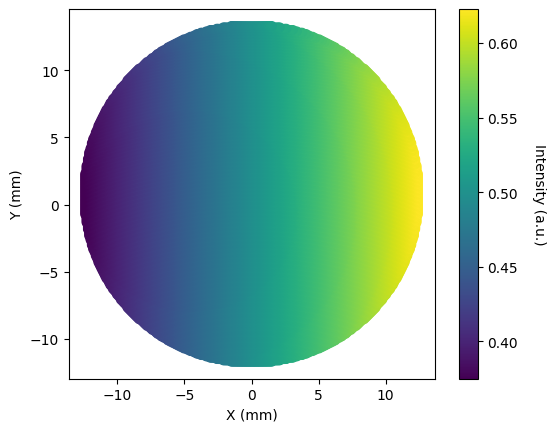

In [9]:
plt.scatter(x1, y1, c=intensity, cmap="viridis")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.axis("image")
cbar = plt.colorbar()
cbar.set_label("Intensity (a.u.)", labelpad=20, rotation=270)
plt.show()

This was a simple example showing how transmission can be made to depend on the intersection point on a surface. We could have built a significantly more complex coating that utilized any of the available ray properties, including:

- Local intersection point on the surface
- Direction cosines of the rays
- Wavelength
- Ray intensity
- Ray optical path length (at point of intersection)
- Ray polarization state
- Surface normals at intersection location


Let's create one more simple example to show how to create a spectrally-dependent coating.

In [10]:
class SpectralCoating(BaseCoating):
    def reflect(self, rays, nx, ny, nz):
        # for reflection, we leave the rays unchanged
        return rays

    def transmit(self, rays, nx, ny, nz):
        transmission = (
            rays.w**2 + 0.2
        )  # apply spectral transmission based on ray wavelength
        rays.i *= transmission
        return rays

Conclusions:

- This tutorial showed how to add custom coatings to surfaces in Optiland.
- Creating a custom coating only requires you inherit from BaseCoating, then define the reflect and transmit methods.
- We created a simple gradient coating and a spectrally-resolved coating.
- More advanced coatings can be made that are dependent on the ray properties, or surface normals.